# Project Name: Digital Twin Predictive System

## Machine Learning Type: Supervised Learning

### Objective: Predict "PV_Wh" variable for Buildings 49, 78 using Regression technique

In [77]:
#!pip install statsmodels

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import datetime as dt
import time
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sqlalchemy import create_engine
import pickle, joblib

In [79]:
def create_sql_engine(conf):
    url = conf["DB_TYPE"]+"+"+conf["ADAPTER"]+":"+"//"+conf["USER"]+":"+conf["PASSWORD"]+"@"+conf["SERVER"]+"/"+conf["DB_NAME"]
    engine = create_engine(url, pool_size=10, max_overflow=20)
    return engine

In [80]:
def load_transfomed_data(df, conf):
    sql_engine = create_sql_engine(conf)
    print("SQL Engine created succesfully..")
    df_name = [x for x in globals() if globals()[x] is df][0]
    table_name = df_name+"_"+"transformed_tbl"
    schema_name = conf["SCHEMA"]
    df.to_sql(table_name, schema=schema_name,con=sql_engine)
    #print("Dataframe "+{df}+" loaded into postgres database successfully!!")

In [81]:
def load_model_feed_data(df, conf):
    sql_engine = create_sql_engine(conf)
    print("SQL Engine created succesfully..")
    df_name = [x for x in globals() if globals()[x] is df][0]
    table_name = df_name+"_"+"ols_input_tbl"
    schema_name = conf["SCHEMA"]
    df.to_sql(table_name, schema=schema_name,con=sql_engine)
    #print("Dataframe "+{df}+" loaded into postgres database successfully!!")

In [82]:
def load_model_error(df, conf):
    sql_engine = create_sql_engine(conf)
    print("SQL Engine created succesfully..")
    df_name = [x for x in globals() if globals()[x] is df][0]
    table_name = df_name+"_"+"ols_output"
    schema_name = conf["SCHEMA"]
    df.to_sql(table_name, schema=schema_name,con=sql_engine)
    #print("Dataframe "+{df}+" loaded into postgres database successfully!!")

In [83]:
db_config =  {
    "ENVIRONMENT": "DEV",
    "CONNECTION_TYPE": "POSTGRES",
    "DB_TYPE": "postgresql",
    "ADAPTER": "psycopg2",
    "SERVER": "text-alanlytic.cpfw4fz0ipqn.us-west-2.rds.amazonaws.com",
    "PORT": "5432",
    "USER": "text_analytic",
    "PASSWORD": "S!tel#321",
    "DB_NAME": "textanalyticdb",
    "SCHEMA": "databot_dev"
    }

In [84]:
month_dict = {1: "January",2: "February", 3: "March", 4: "April",
             5: "May", 6: "June", 7: "July", 8: "August",
             9: "September", 10: "October", 11: "November", 12: "December"}

In [85]:
file_extension = '.csv'

In [86]:
def readCSVToDF(filename):
    #df_data= pd.read_csv(filename)
    df_data= pd.read_csv(filename,index_col='Date_Time',parse_dates=True)
    return df_data



In [87]:
os.chdir("C:/Users/sheer/OneDrive/Documents/digital_twin_project/data_pool/PV_StLucia_Bldng_049_yr2021/")
   
Bldng_049_filenames = [i for i in glob.glob(f"*{file_extension}")]

print("Resultant CSV after joining all CSV files at a particular location -Bldng_049...");

# joining files with concat and read_csv
Bldng_049 = pd.concat(map(pd.read_csv, Bldng_049_filenames), ignore_index=True)
print(Bldng_049.head(5))

Resultant CSV after joining all CSV files at a particular location -Bldng_049...
         Date      Time  PV_W_049  PV_Wh_049
0  2021/01/01  00:00:00         0          0
1  2021/01/01  00:01:00         0          0
2  2021/01/01  00:02:00         0          0
3  2021/01/01  00:03:00         0          0
4  2021/01/01  00:04:00         0          0


In [88]:
os.chdir("C:/Users/sheer/OneDrive/Documents/digital_twin_project/data_pool/PV_StLucia_Bldng_078_yr2021/")

Bldng_078_filenames = [i for i in glob.glob(f"*{file_extension}")]

print("Resultant CSV after joining all CSV files at a particular location -Bldng_078...");

# joining files with concat and read_csv
Bldng_078 = pd.concat(map(pd.read_csv, Bldng_078_filenames), ignore_index=True)
print(Bldng_078.head(5))

Resultant CSV after joining all CSV files at a particular location -Bldng_078...
         Date      Time  PV_W_078  PV_Wh_078
0  2021/01/01  00:00:00       -90          0
1  2021/01/01  00:01:00       -53          0
2  2021/01/01  00:02:00       -52          0
3  2021/01/01  00:03:00         0          0
4  2021/01/01  00:04:00       -50          0


## Feature Engineering for Building 49 data(Date & Time)

In [89]:
'''## Feature Engineering (Date & Time)
Bldng_049["Date_Time"] = Bldng_049["Date"]+" "+Bldng_049["Time"]
Bldng_049["Date_Time"] = Bldng_049["Date_Time"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))
Bldng_049["Date"] = Bldng_049["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d"))
Bldng_049["Year"] = Bldng_049['Date_Time'].dt.year
Bldng_049["Month"] = Bldng_049['Date_Time'].dt.month
Bldng_049["Day"] = Bldng_049['Date_Time'].dt.day
Bldng_049["Hours"] = Bldng_049['Date_Time'].dt.hour
Bldng_049["Minutes"] = Bldng_049['Date_Time'].dt.minute
Bldng_049["Seconds"] = Bldng_049['Date_Time'].dt.second
Bldng_049["Month-str"] = Bldng_049["Month"].replace(month_dict)
Bldng_049.head()'''

'## Feature Engineering (Date & Time)\nBldng_049["Date_Time"] = Bldng_049["Date"]+" "+Bldng_049["Time"]\nBldng_049["Date_Time"] = Bldng_049["Date_Time"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))\nBldng_049["Date"] = Bldng_049["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d"))\nBldng_049["Year"] = Bldng_049[\'Date_Time\'].dt.year\nBldng_049["Month"] = Bldng_049[\'Date_Time\'].dt.month\nBldng_049["Day"] = Bldng_049[\'Date_Time\'].dt.day\nBldng_049["Hours"] = Bldng_049[\'Date_Time\'].dt.hour\nBldng_049["Minutes"] = Bldng_049[\'Date_Time\'].dt.minute\nBldng_049["Seconds"] = Bldng_049[\'Date_Time\'].dt.second\nBldng_049["Month-str"] = Bldng_049["Month"].replace(month_dict)\nBldng_049.head()'

In [90]:
## Feature Engineering for Building 49 data(Date & Time)


def applyFeatureEnggToDF(BldngDF):
    BldngDF["Date_Time"] = BldngDF["Date"]+" "+BldngDF["Time"]
    BldngDF["Date_Time"] = BldngDF["Date_Time"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))
    BldngDF["Date"] = BldngDF["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d"))
    BldngDF["Year"] = BldngDF['Date_Time'].dt.year
    BldngDF["Month"] = BldngDF['Date_Time'].dt.month
    BldngDF["Day"] = BldngDF['Date_Time'].dt.day
    BldngDF["Hours"] = BldngDF['Date_Time'].dt.hour
    BldngDF["Minutes"] = BldngDF['Date_Time'].dt.minute
    BldngDF["Seconds"] = BldngDF['Date_Time'].dt.second
    BldngDF["Month-str"] = BldngDF["Month"].replace(month_dict)

    BldngDF['DayOfTheWeek'] = BldngDF['Date_Time'].dt.dayofweek
    BldngDF['TheQuarter'] = BldngDF['Date_Time'].dt.quarter
    
    
    #BldngDF.head()
    return  BldngDF



In [91]:
## Feature Engineering (Date & Time) Bldng_049

Bldng_049 = applyFeatureEnggToDF(Bldng_049)
Bldng_049.set_index("Date_Time", inplace = True)

Bldng_049.to_csv("C:/Users/sheer/OneDrive/Documents/digital_twin_project/integration_data/bldng049_tranformed_data.csv", index=False)




Bldng_049.head(1) 

,Date,Time,PV_W_049,PV_Wh_049,Year,Month,Day,Hours,Minutes,Seconds,Month-str,DayOfTheWeek,TheQuarter
Date_Time,,,,,,,,,,,,,
2021-01-01,2021-01-01,00:00:00,0,0,2021,1,1,0,0,0,January,4,1


## EXPLORATORY DATA CHARTS

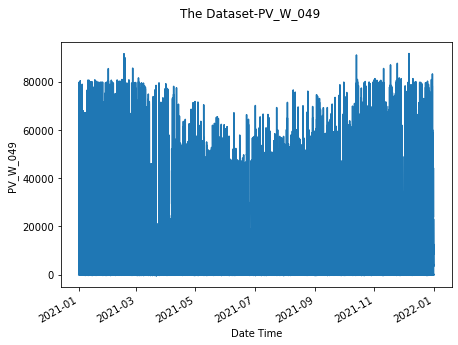

In [92]:
%matplotlib inline


df_fe_Bldng_365D = Bldng_049
def drawChart(df,parameterUsed,xlabel, ylabel, supertitle,width, height):
    fig = plt.figure()
    df[parameterUsed].plot(figsize=(width,height))        
    fig.suptitle(supertitle)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


drawChart(df_fe_Bldng_365D,"PV_W_049","Date Time", "PV_W_049", "The Dataset-PV_W_049",7, 5) 




In [93]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>


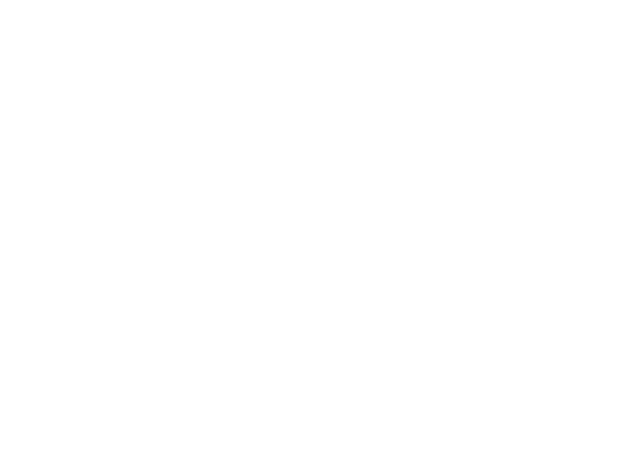

In [94]:
drawChart(df_fe_Bldng_365D,"PV_Wh_049","Date Time", "PV_Wh_049", "The Dataset showing PV_Wh_049",7, 5) 


<IPython.core.display.Javascript object>


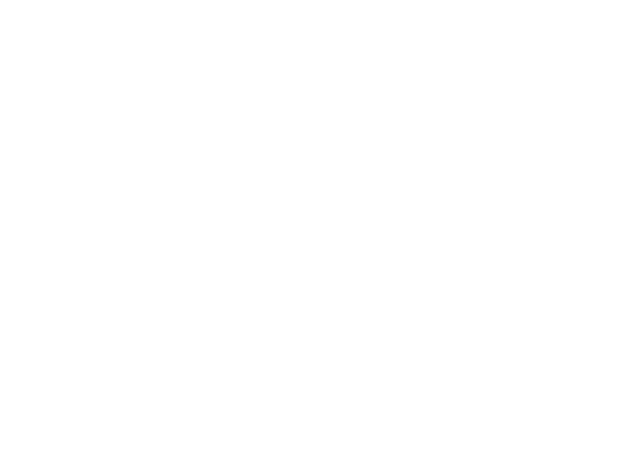

<IPython.core.display.Javascript object>


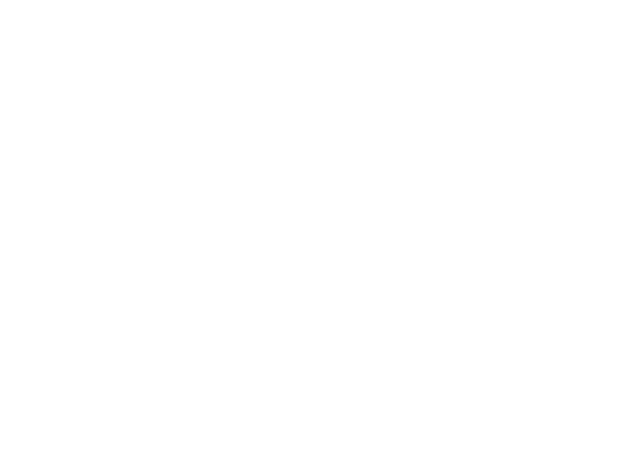

<IPython.core.display.Javascript object>


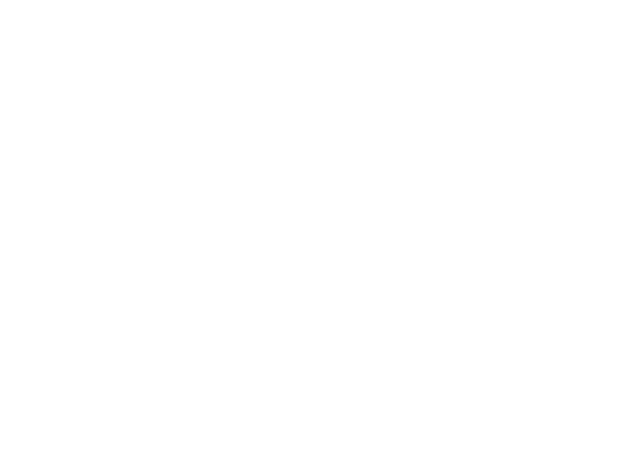

<IPython.core.display.Javascript object>


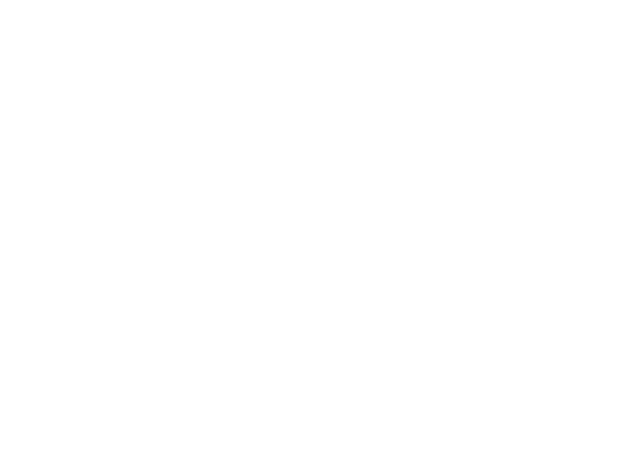

<IPython.core.display.Javascript object>


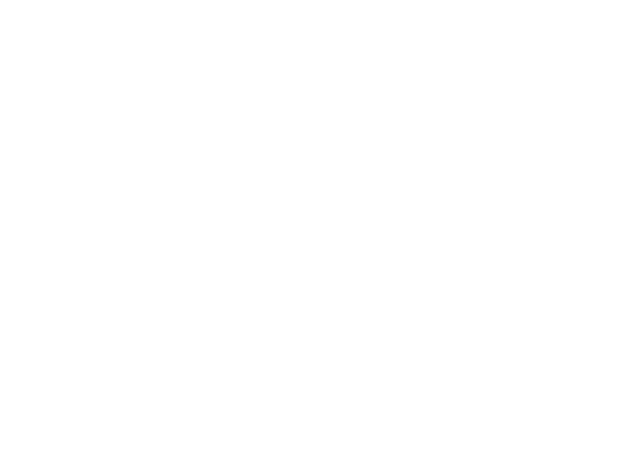

<IPython.core.display.Javascript object>


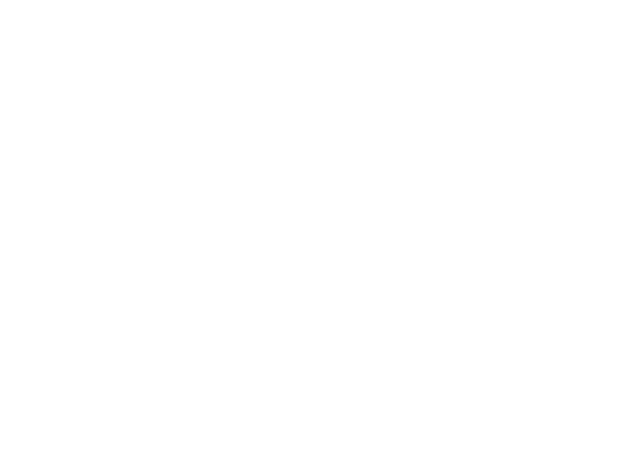

In [95]:
# How does the data appear in a day, week and month



#building 49 Building PV_W

drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-02')],"PV_W_049","Date Time","PV_W_049","Sample chart of a Day PV_W_049",7, 5) 
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-08')],"PV_W_049","Date Time","PV_W_049","Sample chart of a Week PV_W_049",7, 5) 
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-31')],"PV_W_049","Date Time","PV_W_049","Sample chart of a Month PV_W_049",7, 5) 
                                                                                                                

#building 49 Building PV_Wh
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-02')],"PV_Wh_049","Date Time","PV_Wh_049","Sample chart of a Day PV_Wh_049",7, 5) 
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-08')],"PV_Wh_049","Date Time","PV_Wh_049","Sample chart of a Week PV_Wh_049",7, 5) 
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-31')],"PV_Wh_049","Date Time","PV_Wh_049","Sample chart of a Month PV_Wh_049",7, 5) 
                                                                                                                


<IPython.core.display.Javascript object>


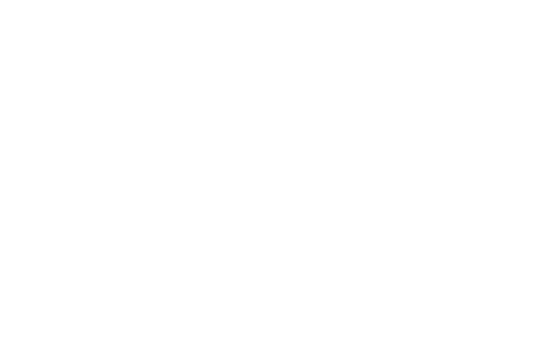

In [96]:

def drawBoxPlotChart(df,feature,parameterUsed,xlabel, ylabel, title,width, height):
    #fig = plt.figure()
    df.boxplot(by =feature, column =[parameterUsed], grid = False,showmeans=True)
    
    #df[parameterUsed].plot(figsize=(width,height))        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    
drawBoxPlotChart(df_fe_Bldng_365D,"Hours", "PV_W_049","Hours", "PV_W_049", "PV_W_049 By Hour- Feature",7, 5)
# You can see the hours when the PV is max and min. 


<IPython.core.display.Javascript object>


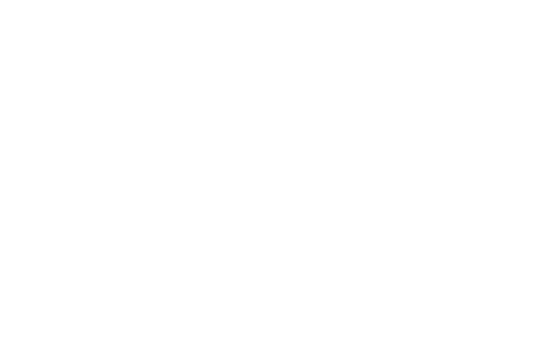

In [97]:
drawBoxPlotChart(df_fe_Bldng_365D,"Month", "PV_W_049","Month", "PV_W_049", "PV_W_049 By Month- Feature",7, 5)


<IPython.core.display.Javascript object>


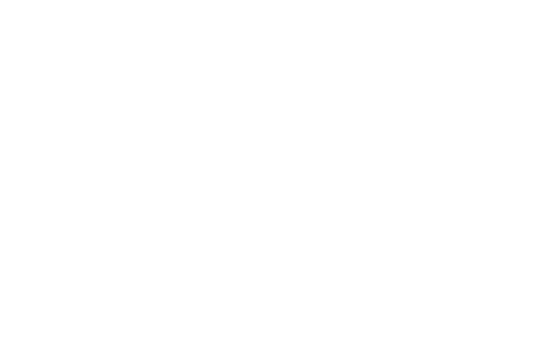

In [98]:
drawBoxPlotChart(df_fe_Bldng_365D,"DayOfTheWeek", "PV_W_049","DayOfTheWeek", "PV_W_049", "PV_W_049 By Day of the week- Feature",7, 5)


<IPython.core.display.Javascript object>


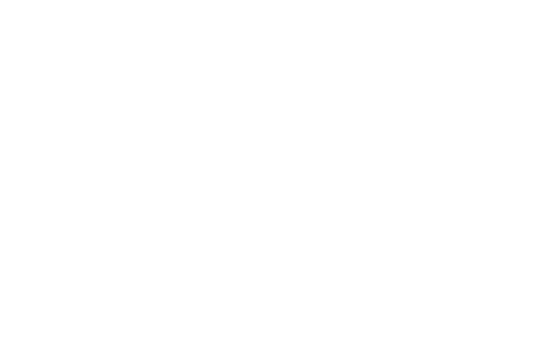

In [99]:
drawBoxPlotChart(df_fe_Bldng_365D,"TheQuarter", "PV_W_049","TheQuarter", "PV_W_049", "PV_W_049 Quarter- Feature",7, 5)


<IPython.core.display.Javascript object>


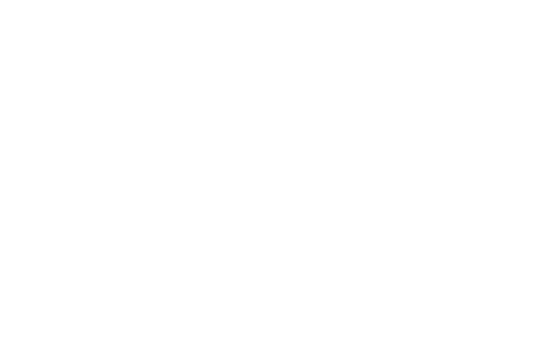

<IPython.core.display.Javascript object>


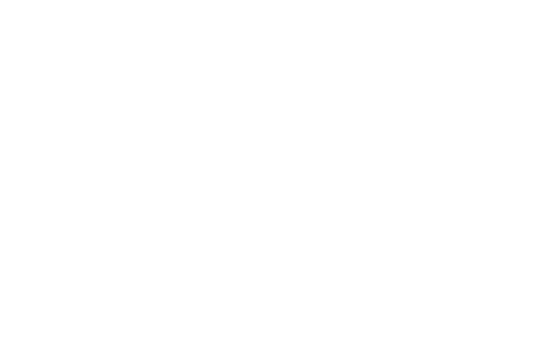

<IPython.core.display.Javascript object>


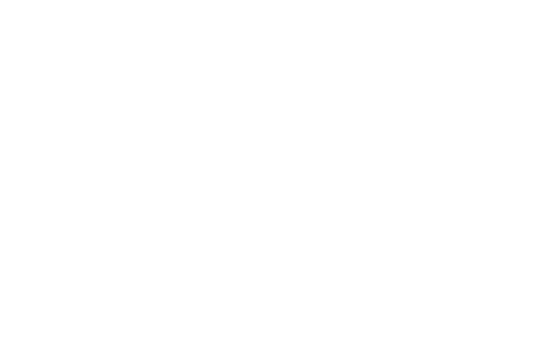

<IPython.core.display.Javascript object>


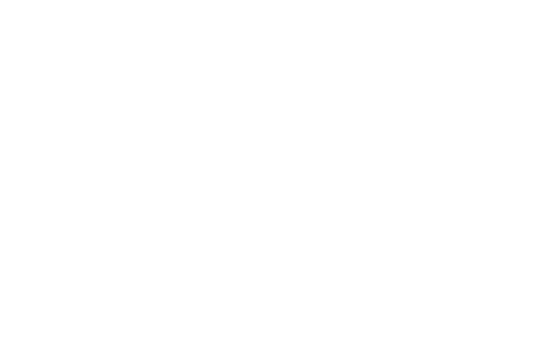

In [100]:


drawBoxPlotChart(df_fe_Bldng_365D,"Hours", "PV_Wh_049","Hours", "PV_Wh_049", "PV_Wh_049 By Hour- Feature",7, 5)

drawBoxPlotChart(df_fe_Bldng_365D,"Month", "PV_Wh_049","Month", "PV_Wh_049", "PV_Wh_049 By Month- Feature",7, 5)

drawBoxPlotChart(df_fe_Bldng_365D,"DayOfTheWeek", "PV_Wh_049","DayOfTheWeek", "PV_Wh_049", "PV_Wh_049 By Day of the week- Feature",7, 5)

drawBoxPlotChart(df_fe_Bldng_365D,"TheQuarter", "PV_Wh_049","TheQuarter", "PV_Wh_049", "PV_Wh_049 Quarter- Feature",7, 5)


In [101]:
Bldng_049.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525595 entries, 2021-01-01 00:00:00 to 2021-12-31 23:59:00
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          525595 non-null  datetime64[ns]
 1   Time          525595 non-null  object        
 2   PV_W_049      525595 non-null  int64         
 3   PV_Wh_049     525595 non-null  int64         
 4   Year          525595 non-null  int64         
 5   Month         525595 non-null  int64         
 6   Day           525595 non-null  int64         
 7   Hours         525595 non-null  int64         
 8   Minutes       525595 non-null  int64         
 9   Seconds       525595 non-null  int64         
 10  Month-str     525595 non-null  object        
 11  DayOfTheWeek  525595 non-null  int64         
 12  TheQuarter    525595 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 56.1+ MB


In [102]:
Bldng_049.describe()



,PV_W_049,PV_Wh_049,Year,Month,Day,Hours,Minutes,Seconds,DayOfTheWeek,TheQuarter
count,525595.000000,525595.000000,525595.0,525595.000000,525595.000000,525595.000000,525595.000000,525595.0,525595.000000,525595.000000
mean,12513.156328,152943.404435,2021.0,6.526006,15.720441,11.499982,29.500047,0.0,3.002738,2.509582
std,18723.206704,146837.599095,0.0,3.447843,8.796225,6.922204,17.318141,0.0,1.997948,1.116767
min,-650.000000,0.000000,2021.0,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000
25%,0.000000,20.000000,2021.0,4.000000,8.000000,5.000000,15.000000,0.0,1.000000,2.000000
50%,0.000000,126544.000000,2021.0,7.000000,16.000000,12.000000,29.000000,0.0,3.000000,3.000000
75%,21050.000000,281322.000000,2021.0,10.000000,23.000000,17.000000,45.000000,0.0,5.000000,4.000000
max,91600.000000,536352.000000,2021.0,12.000000,31.000000,23.000000,59.000000,0.0,6.000000,4.000000


In [103]:
Bldng_049.isnull().sum()


Date            0
Time            0
PV_W_049        0
PV_Wh_049       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
dtype: int64

In [104]:
Bldng_049.dtypes



Date            datetime64[ns]
Time                    object
PV_W_049                 int64
PV_Wh_049                int64
Year                     int64
Month                    int64
Day                      int64
Hours                    int64
Minutes                  int64
Seconds                  int64
Month-str               object
DayOfTheWeek             int64
TheQuarter               int64
dtype: object

In [105]:
Bldng_049.shape



(525595, 13)

In [106]:
print("No of columns",len(Bldng_049.columns) , Bldng_049.columns)

No of columns 13 Index(['Date', 'Time', 'PV_W_049', 'PV_Wh_049', 'Year', 'Month', 'Day',
       'Hours', 'Minutes', 'Seconds', 'Month-str', 'DayOfTheWeek',
       'TheQuarter'],
      dtype='object')


<IPython.core.display.Javascript object>


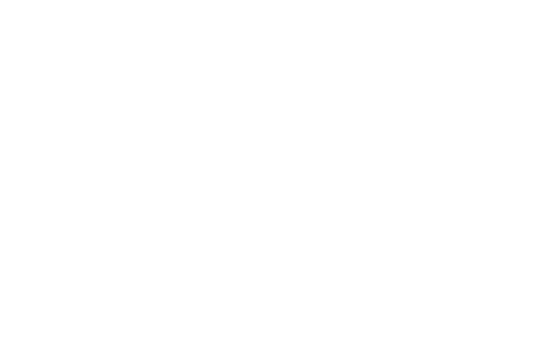

In [107]:

#plt.figure(figsize=(7,5))

Bldng_049.plot(kind='scatter',
        x='PV_W_049',
        y='PV_Wh_049',
        title='Power vs. Energy')
plt.show()

<IPython.core.display.Javascript object>


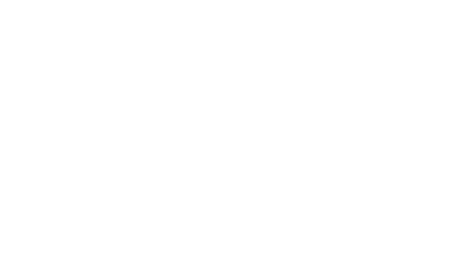

In [108]:
import numpy as np
#fig = plt.figure(5,3)
fig = plt.figure(figsize=(5,3))

a1 = fig.add_axes([0,0,1,1])
a1.plot(Bldng_049.Date,Bldng_049.PV_W_049)
a1.set_ylabel('PV_W_049 - Power')
a2 = a1.twinx()
a2.plot(Bldng_049.Date,Bldng_049.PV_Wh_049,color='red')
a2.set_ylabel('PV_Wh_049 - Energy')
fig.legend(labels = ('Power','Energy'),loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


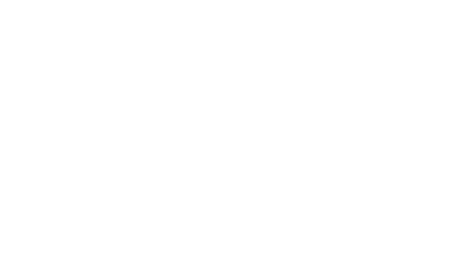

In [109]:
plt.figure(figsize=(5,3))

Bldng_049['PV_W_049'].plot(kind='kde', title='PV_W')
plt.show() 

# Outlier Analysis

<IPython.core.display.Javascript object>


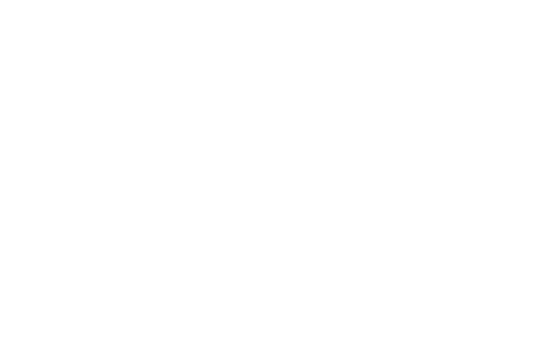

<IPython.core.display.Javascript object>


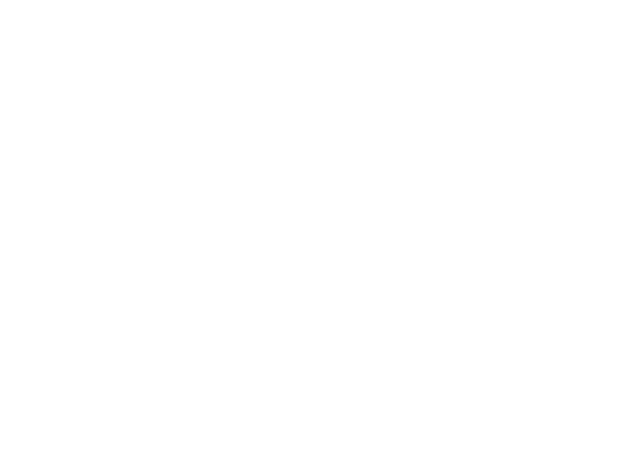

In [110]:
fig = plt.figure()
df=Bldng_049
df['PV_Wh_049'].plot(kind='hist')
plt.show()

fig = plt.figure()

plt.scatter(df.index, df['PV_Wh_049'])

In [111]:
df.query('PV_Wh_049 > 480000')['PV_Wh_049'] \
    .plot(style='-',
          figsize=(7, 5),
          title='Outliers')

<AxesSubplot:title={'center':'Outliers'}, xlabel='Date_Time'>

In [112]:
df = df.query('PV_Wh_049 <= 480000').copy()
Bldng_049 = df

In [113]:
# check for NULL values 
Bldng_049.isnull().sum()

Date            0
Time            0
PV_W_049        0
PV_Wh_049       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
dtype: int64

In [114]:
#Remove those null values
if Bldng_049.isnull().sum().sum() != 0:
    Bldng_049 = Bldng_049.dropna()
Bldng_049.isnull().sum()

Date            0
Time            0
PV_W_049        0
PV_Wh_049       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
dtype: int64

In [115]:

%matplotlib inline

""" 

plt.figure(figsize=(12,9))
sns.pairplot(Bldng_049, vars=['PV_W_049', 'PV_Wh_049', 'Month', 'Hours'], hue='Hours')
plt.show()

""" 


" \n\nplt.figure(figsize=(12,9))\nsns.pairplot(Bldng_049, vars=['PV_W_049', 'PV_Wh_049', 'Month', 'Hours'], hue='Hours')\nplt.show()\n\n"

## Feature Engineering for Building 78 data(Date & Time)

In [116]:
'''## Feature Engineering (Date & Time)
Bldng_078["Date_Time"] = Bldng_078["Date"]+" "+Bldng_078["Time"]
Bldng_078["Date_Time"] = Bldng_078["Date_Time"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))
Bldng_078["Date"] = Bldng_078["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d"))
Bldng_078["Year"] = Bldng_078['Date_Time'].dt.year
Bldng_078["Month"] = Bldng_078['Date_Time'].dt.month
Bldng_078["Day"] = Bldng_078['Date_Time'].dt.day
Bldng_078["Hours"] = Bldng_078['Date_Time'].dt.hour
Bldng_078["Minutes"] = Bldng_078['Date_Time'].dt.minute
Bldng_078["Seconds"] = Bldng_078['Date_Time'].dt.second
Bldng_078["Month-str"] = Bldng_078["Month"].replace(month_dict)
Bldng_078.head()'''

'## Feature Engineering (Date & Time)\nBldng_078["Date_Time"] = Bldng_078["Date"]+" "+Bldng_078["Time"]\nBldng_078["Date_Time"] = Bldng_078["Date_Time"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))\nBldng_078["Date"] = Bldng_078["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y/%m/%d"))\nBldng_078["Year"] = Bldng_078[\'Date_Time\'].dt.year\nBldng_078["Month"] = Bldng_078[\'Date_Time\'].dt.month\nBldng_078["Day"] = Bldng_078[\'Date_Time\'].dt.day\nBldng_078["Hours"] = Bldng_078[\'Date_Time\'].dt.hour\nBldng_078["Minutes"] = Bldng_078[\'Date_Time\'].dt.minute\nBldng_078["Seconds"] = Bldng_078[\'Date_Time\'].dt.second\nBldng_078["Month-str"] = Bldng_078["Month"].replace(month_dict)\nBldng_078.head()'

In [117]:
## Feature Engineering for Building 78 data(Date & Time)

Bldng_078 = applyFeatureEnggToDF(Bldng_078)
Bldng_078.set_index("Date_Time", inplace = True)


Bldng_078.to_csv("C:/Users/sheer/OneDrive/Documents/digital_twin_project/integration_data/bldng078_tranformed_data.csv", index=False)




Bldng_078.head(1)

,Date,Time,PV_W_078,PV_Wh_078,Year,Month,Day,Hours,Minutes,Seconds,Month-str,DayOfTheWeek,TheQuarter
Date_Time,,,,,,,,,,,,,
2021-01-01,2021-01-01,00:00:00,-90,0,2021,1,1,0,0,0,January,4,1


In [118]:
Bldng_078.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503384 entries, 2021-01-01 00:00:00 to 2021-12-21 01:36:00
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          503384 non-null  datetime64[ns]
 1   Time          503384 non-null  object        
 2   PV_W_078      503384 non-null  int64         
 3   PV_Wh_078     503384 non-null  int64         
 4   Year          503384 non-null  int64         
 5   Month         503384 non-null  int64         
 6   Day           503384 non-null  int64         
 7   Hours         503384 non-null  int64         
 8   Minutes       503384 non-null  int64         
 9   Seconds       503384 non-null  int64         
 10  Month-str     503384 non-null  object        
 11  DayOfTheWeek  503384 non-null  int64         
 12  TheQuarter    503384 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 53.8+ MB


In [119]:
Bldng_078.describe()

,PV_W_078,PV_Wh_078,Year,Month,Day,Hours,Minutes,Seconds,DayOfTheWeek,TheQuarter
count,503384.000000,5.033840e+05,503384.0,503384.000000,503384.000000,503384.000000,503384.000000,503384.0,503384.000000,503384.000000
mean,6568.247360,3.142186e+05,2021.0,6.291604,15.453290,11.499046,29.497608,0.0,2.990157,2.445904
std,10770.536464,9.806803e+06,0.0,3.327765,8.759668,6.928094,17.318664,0.0,2.006373,1.096889
min,-592.000000,0.000000e+00,2021.0,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000
25%,0.000000,9.400000e+01,2021.0,3.000000,8.000000,5.000000,14.000000,0.0,1.000000,1.000000
50%,15.000000,5.587500e+04,2021.0,6.000000,15.000000,12.000000,29.000000,0.0,3.000000,2.000000
75%,9887.000000,1.378750e+05,2021.0,9.000000,23.000000,18.000000,44.000000,0.0,5.000000,3.000000
max,67480.000000,4.116092e+08,2021.0,12.000000,31.000000,23.000000,59.000000,0.0,6.000000,4.000000


In [120]:

Bldng_078.isnull().sum()

Date            0
Time            0
PV_W_078        0
PV_Wh_078       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
dtype: int64

In [121]:

Bldng_078.dtypes


Date            datetime64[ns]
Time                    object
PV_W_078                 int64
PV_Wh_078                int64
Year                     int64
Month                    int64
Day                      int64
Hours                    int64
Minutes                  int64
Seconds                  int64
Month-str               object
DayOfTheWeek             int64
TheQuarter               int64
dtype: object

In [122]:


Bldng_078.shape

(503384, 13)

In [123]:


print("No of columns",len(Bldng_078.columns) , Bldng_078.columns)


No of columns 13 Index(['Date', 'Time', 'PV_W_078', 'PV_Wh_078', 'Year', 'Month', 'Day',
       'Hours', 'Minutes', 'Seconds', 'Month-str', 'DayOfTheWeek',
       'TheQuarter'],
      dtype='object')


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


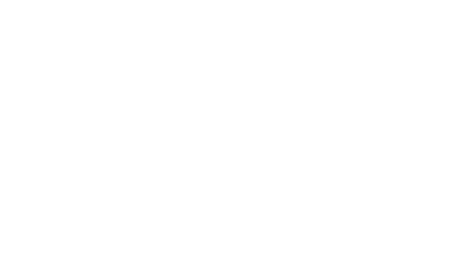

In [124]:
%matplotlib auto

import numpy as np
#fig = plt.figure(5,3)
fig = plt.figure(figsize=(5,3))

a1 = fig.add_axes([0,0,1,1])
a1.plot(Bldng_078.Date,Bldng_078.PV_W_078)
a1.set_ylabel('PV_W_078 - Power')
a2 = a1.twinx()
a2.plot(Bldng_078.Date,Bldng_078.PV_Wh_078,color='red')
a2.set_ylabel('PV_Wh_078 - Energy')
fig.legend(labels = ('Power','Energy'),loc='upper left')
plt.show()

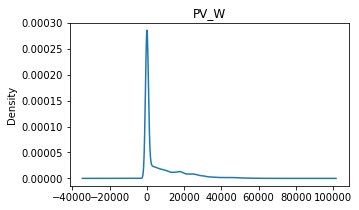

In [125]:
%matplotlib inline
plt.figure(figsize=(5,3))

Bldng_078['PV_W_078'].plot(kind='kde', title='PV_W')
plt.show() 

In [126]:
%matplotlib inline

"""

plt.figure(figsize=(12,9))
sns.pairplot(Bldng_078, vars=['PV_W_078', 'PV_Wh_078', 'Month', 'Hours'], hue='Hours')
plt.show()

"""

"\n\nplt.figure(figsize=(12,9))\nsns.pairplot(Bldng_078, vars=['PV_W_078', 'PV_Wh_078', 'Month', 'Hours'], hue='Hours')\nplt.show()\n\n"

It can be observed the data for building 078 has even PV_W data while the PV_Wh data is flat..


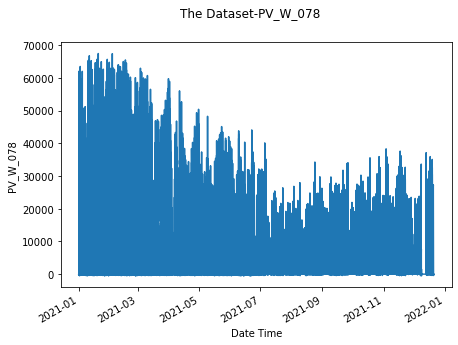

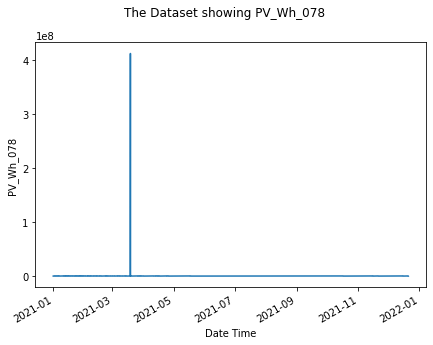

In [127]:
#EXPLORATORY DATA ANALYSIS
df_fe_Bldng_365D =Bldng_078

drawChart(df_fe_Bldng_365D,"PV_W_078","Date Time", "PV_W_078", "The Dataset-PV_W_078",7, 5) 

 

drawChart(df_fe_Bldng_365D,"PV_Wh_078","Date Time", "PV_Wh_078", "The Dataset showing PV_Wh_078",7, 5) 

print("It can be observed the data for building 078 has even PV_W data while the PV_Wh data is flat..")

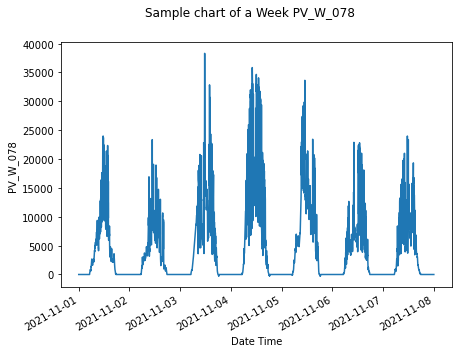

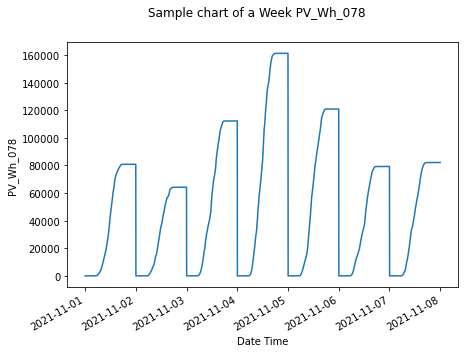

In [128]:
#

import warnings
warnings.filterwarnings(action='once')
df_fe_Bldng_365D.head(1)
df= df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-11-01') & (df_fe_Bldng_365D.index < '2021-11-08')]
drawChart(df,"PV_W_078","Date Time","PV_W_078","Sample chart of a Week PV_W_078",7, 5) 

df= df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-11-01') & (df_fe_Bldng_365D.index < '2021-11-08')]
drawChart(df,"PV_Wh_078","Date Time","PV_Wh_078","Sample chart of a Week PV_Wh_078",7, 5) 


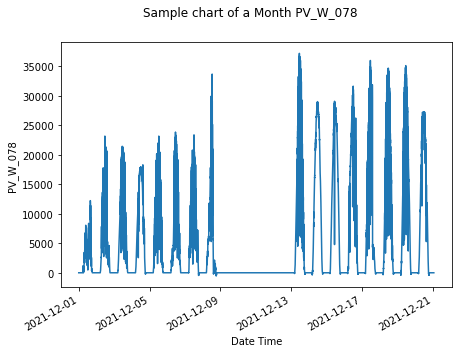

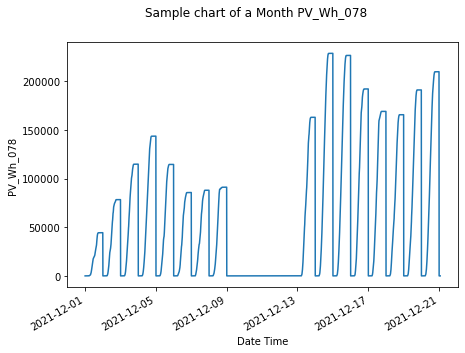

In [129]:
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-31')],"PV_W_078","Date Time","PV_W_078","Sample chart of a Month PV_W_078",7, 5) 

drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-31')],"PV_Wh_078","Date Time","PV_Wh_078","Sample chart of a Month PV_Wh_078",7, 5) 


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


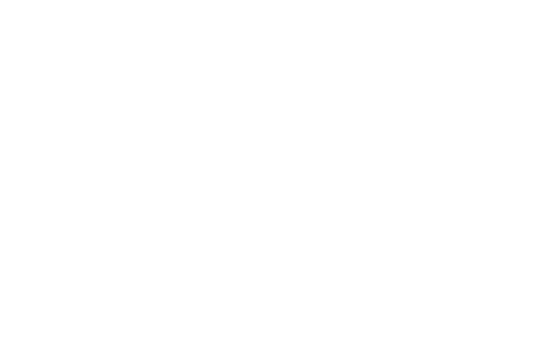

In [130]:
%matplotlib auto
#building 78 Building PV_Wh
start ='2021-12-6'
end = '2021-12-7'
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > start) & (df_fe_Bldng_365D.index < end)],"PV_W_078","Date Time","PV_W_078","Sample chart of a Day PV_W_078",7, 5) 
#df_fe_Bldng_365D

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


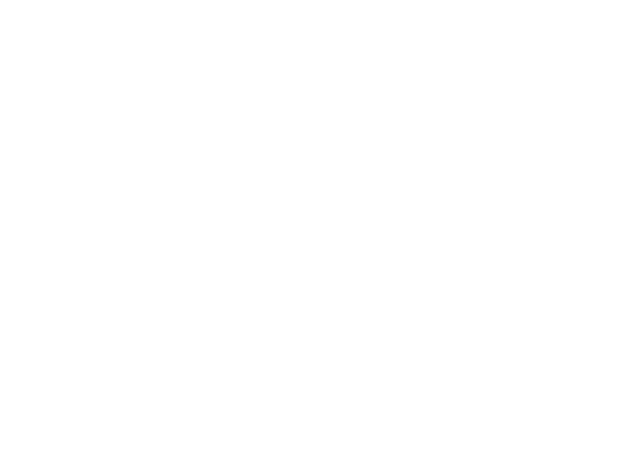

In [131]:
%matplotlib auto
#building 78 Building PV_Wh
start ='2021-12-6'
end = '2021-12-7'
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > start) & (df_fe_Bldng_365D.index < end)],"PV_Wh_078","Date Time","PV_Wh_078","Sample chart of a Day PV_Wh_078",7, 5) 
#df_fe_Bldng_365D

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


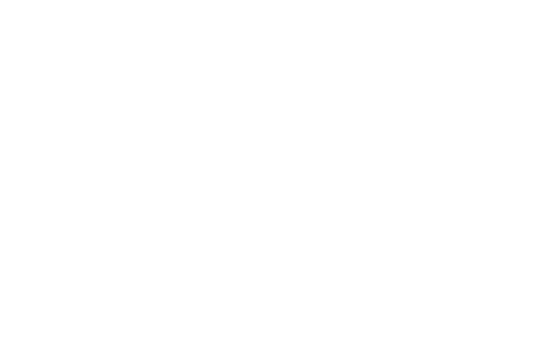

In [132]:
%matplotlib auto
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-08')],"PV_W_078","Date Time","PV_W_078","Sample chart of a Week PV_W_078",7, 5) 


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


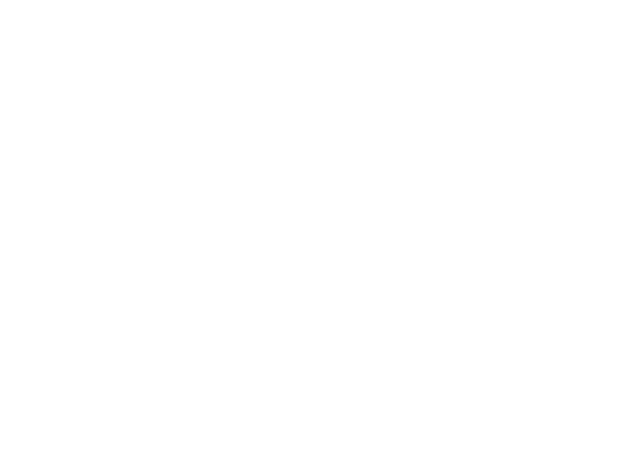

In [133]:

%matplotlib auto
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-08')],"PV_Wh_078","Date Time","PV_Wh_078","Sample chart of a Week PV_Wh_078",7, 5) 


<IPython.core.display.Javascript object>


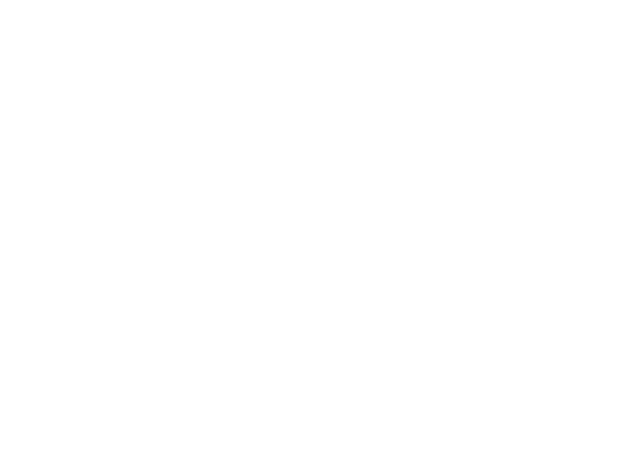

In [134]:
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-31')],"PV_W_078","Date Time","PV_W_078","Sample chart of a Month PV_W_078",7, 5) 

<IPython.core.display.Javascript object>


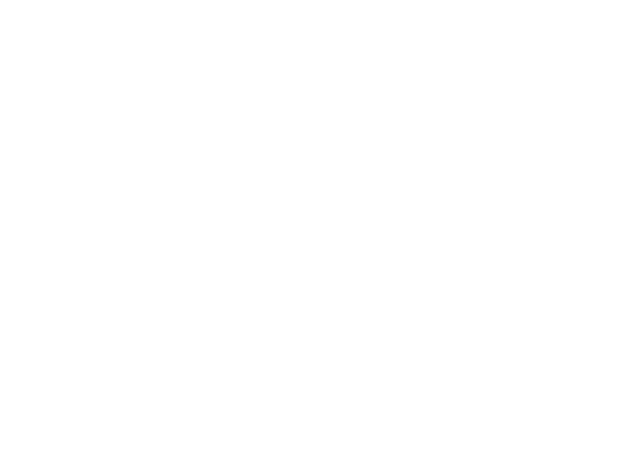

In [135]:
drawChart(df_fe_Bldng_365D.loc[(df_fe_Bldng_365D.index > '2021-12-01') & (df_fe_Bldng_365D.index < '2021-12-31')],"PV_Wh_078","Date Time","PV_Wh_078","Sample chart of a Month PV_Wh_078",7, 5) 

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


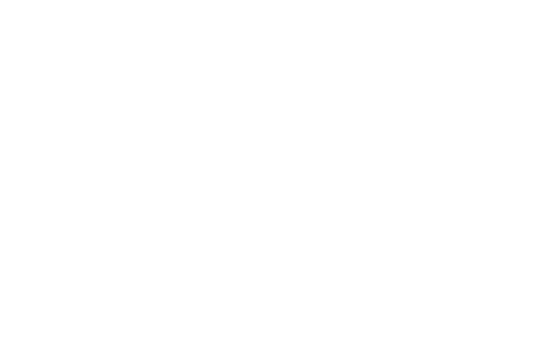

In [136]:
%matplotlib auto
drawBoxPlotChart(df_fe_Bldng_365D,"Hours", "PV_W_078","Hours", "PV_W_078", "PV_W_078 By Hour- Feature",7, 5)



Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


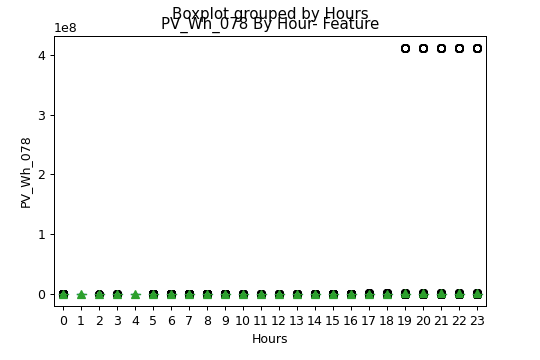

In [137]:
%matplotlib auto
drawBoxPlotChart(df_fe_Bldng_365D,"Hours", "PV_Wh_078","Hours", "PV_Wh_078", "PV_Wh_078 By Hour- Feature",7, 5)



<IPython.core.display.Javascript object>


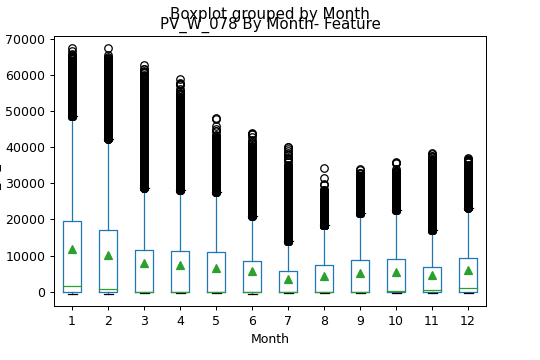

In [138]:
drawBoxPlotChart(df_fe_Bldng_365D,"Month", "PV_W_078","Month", "PV_W_078", "PV_W_078 By Month- Feature",7, 5)


<IPython.core.display.Javascript object>


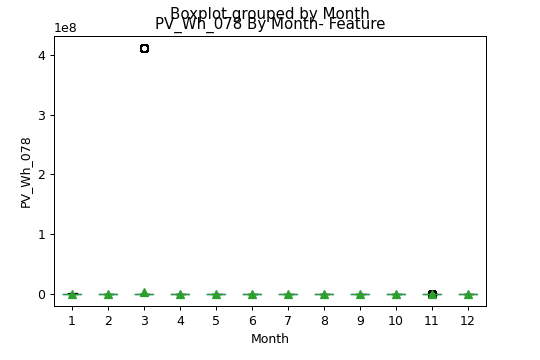

In [139]:
drawBoxPlotChart(df_fe_Bldng_365D,"Month", "PV_Wh_078","Month", "PV_Wh_078", "PV_Wh_078 By Month- Feature",7, 5)


<IPython.core.display.Javascript object>


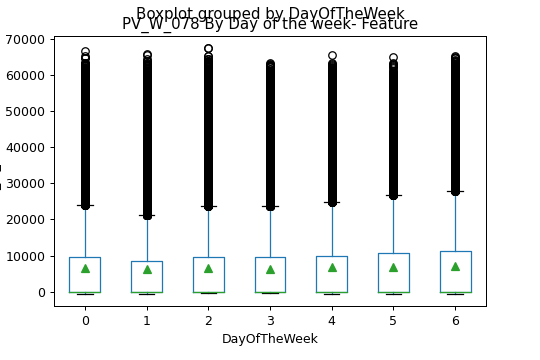

In [140]:
drawBoxPlotChart(df_fe_Bldng_365D,"DayOfTheWeek", "PV_W_078","DayOfTheWeek", "PV_W_078", "PV_W_078 By Day of the week- Feature",7, 5)


<IPython.core.display.Javascript object>


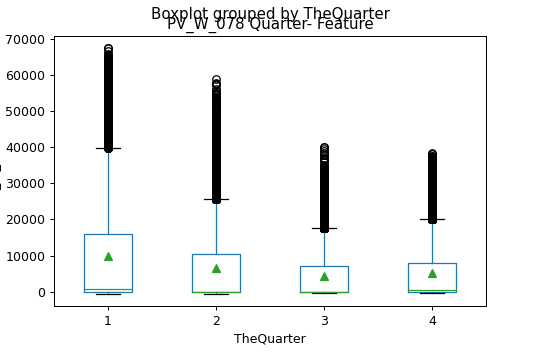

In [141]:
drawBoxPlotChart(df_fe_Bldng_365D,"TheQuarter", "PV_W_078","TheQuarter", "PV_W_078", "PV_W_078 Quarter- Feature",7, 5)


### Downloading Dataframe data to CSV File

In [143]:
#Bldng_049.to_csv("C:/Users/csury001/Downloads/bldng049_tranformed_data.csv", index=False)
#Bldng_078.to_csv("C:/Users/csury001/Downloads/bldng078_tranformed_data.csv", index=False)
#load_df_db(Bldng_049, db_config)
#load_df_db(Bldng_078, db_config)

#consider saving it in project folder/downloads/

# Exploratory Data Analysis

<IPython.core.display.Javascript object>


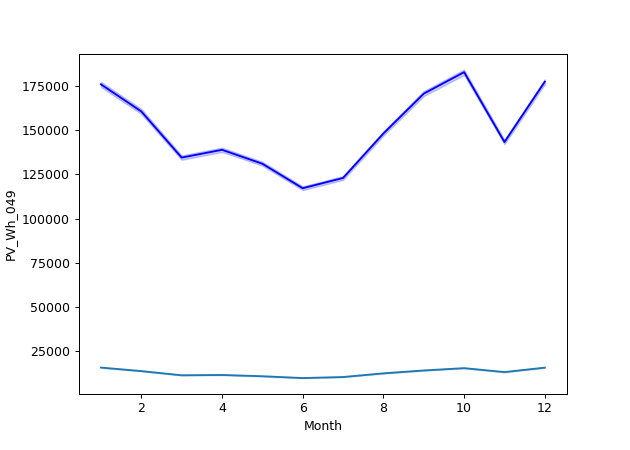

D:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [144]:
plt.figure(figsize=(7,5))
sns.lineplot(Bldng_049["Month"], Bldng_049["PV_Wh_049"],color='blue')

sns.lineplot(Bldng_049["Month"], Bldng_049["PV_W_049"])

plt.show()

Note: At 1st Month PV_W_049 value is high compared to the other months

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


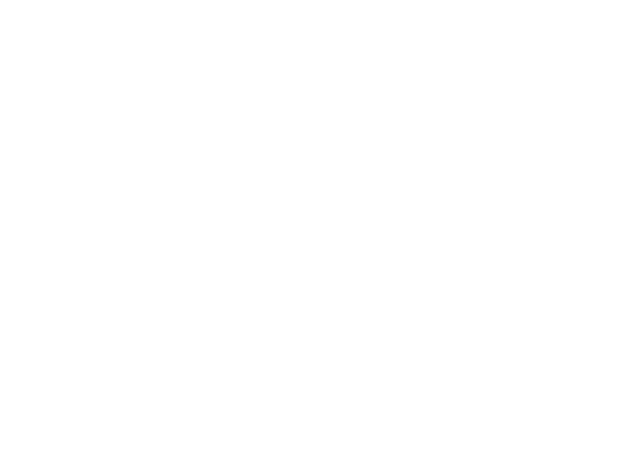

D:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Softwares\Anaconda\lib\site-

In [146]:
%matplotlib auto

import warnings
warnings.filterwarnings(action='once')


plt.figure(figsize=(7,5))
sns.lineplot(Bldng_049["Hours"], Bldng_049["PV_W_049"],color='green')
sns.lineplot(Bldng_049["Hours"], Bldng_049["PV_Wh_049"],color='blue')

sns.lineplot(Bldng_078["Hours"], Bldng_078["PV_W_078"])
sns.lineplot(Bldng_078["Hours"], Bldng_078["PV_Wh_078"],color='red')

plt.show()

Note: At 11th hour PV_W_049 value is high

In [147]:
#plt.figure(figsize=(15,7))
#sns.lineplot(Bldng_049["Date"], Bldng_049["PV_W_049"])
#plt.show()

In [148]:
#plt.figure(figsize=(15,7))
#sns.lineplot(Bldng_078["Month"], Bldng_078["PV_W_078"])
#plt.show()

In [149]:
#plt.figure(figsize=(15,7))
#sns.lineplot(Bldng_078["Hours"], Bldng_078["PV_W_078"])
#plt.show()

In [150]:
#plt.figure(figsize=(15,7))
#sns.lineplot(Bldng_078["Date"], Bldng_078["PV_W_078"])
#plt.show()

In [151]:
#plt.figure(figsize=(15,7))
#sns.lineplot(Bldng_049["Date"], Bldng_049["PV_Wh_049"])
#plt.show()

In [152]:
#plt.figure(figsize=(15,7))
#sns.lineplot(Bldng_078["Date"], Bldng_078["PV_Wh_078"])
#plt.show()

### Correlation

<AxesSubplot:>

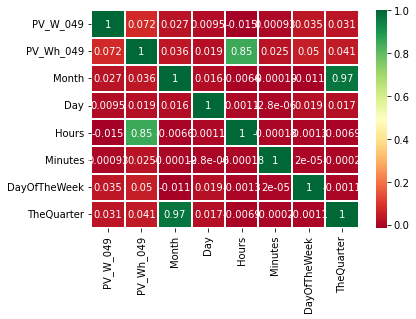

In [153]:
%matplotlib inline
sns.heatmap(Bldng_049.drop(["Year", "Seconds"],axis=1).corr(), linewidths=.25,cmap="RdYlGn", annot=True)

Note: Hours column has high positive correlation with the target variable (PV_Wh_049)

# ML Pipeline Creation (Using Ordinary Least Squares)

## Building-49

In [154]:
Y_49 = Bldng_049.PV_Wh_049
#X_49 = Bldng_049.drop(columns=["Date", "Time", "PV_Wh_049", "Date_Time", "Year","Day", "Minutes", "Seconds", "Month", "Month-str"])
print("Bivarariate regression ..")

X_49 = Bldng_049.Hours
X_49 = sm.add_constant(X_49)

#ols_49 = sm.OLS(Y_49, X_49).fit()

# Print out the statistics
#ols_49.summary()

Bivarariate regression ..


D:\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [155]:
X_train_49, X_test_49, y_train_49, y_test_49 = train_test_split(X_49, Y_49, test_size=0.3, random_state=1)

In [156]:
X_train_49.shape, y_train_49.shape

((365108, 2), (365108,))

In [157]:
X_test_49.shape, y_test_49.shape

((156475, 2), (156475,))

In [158]:
ols_49 = sm.OLS(y_train_49, X_train_49).fit()
# Print out the statistics
ols_49.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PV_Wh_049   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                 9.514e+05
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:09:47   Log-Likelihood:            -4.6209e+06
No. Observations:              365108   AIC:                         9.242e+06
Df Residuals:                  365106   BIC:                         9.242e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.274e+04    243.101   -216.927      0.000   -5.32e+04   -5.23e+04
Hours       1.775e+04     18.203    975.376      0.000    1.77e+04    1.78e+04
==============================================================================
Omnibus:                     6725.496   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14140.278
Skew:                           0.026   Prob(JB):                         0.00
Kurtosis:                       3.963   Cond. No.                         26.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [159]:
train_49_preds = ols_49.predict(X_train_49)
test_49_preds = ols_49.predict(X_test_49)

In [160]:
print("RMSE-49 (Train): {}".format(np.sqrt(mean_squared_error(y_train_49, train_49_preds))))
print("RMSE-49 (Test): {}".format(np.sqrt(mean_squared_error(y_test_49, test_49_preds))))

RMSE-49 (Train): 75905.57696324796
RMSE-49 (Test): 75977.00201760697


In [161]:
print("R2-49 (Train): {}".format(r2_score(y_train_49, train_49_preds)))
print("R2-49 (Test): {}".format(r2_score(y_test_49, test_49_preds)))

R2-49 (Train): 0.7226616641079753
R2-49 (Test): 0.7228123680938117


In [162]:
RMSE_49_Train = np.sqrt(mean_squared_error(y_train_49, train_49_preds))
RMSE_49_Test = np.sqrt(mean_squared_error(y_test_49, test_49_preds))
R2_49_Train = r2_score(y_train_49, train_49_preds)
R2_49_Test = r2_score(y_test_49, test_49_preds)


 

rmse_r2_eachmodel= pd.DataFrame({'Model':'OLS',
                            'Building':'049',
                           'Data':'TRAIN',
                           'RunNumber':'RUN1',
                           'Params':'PARAM1',
                           'RMSE': RMSE_49_Train,
                           'R2': R2_49_Train
                          }, index=[0]) 

df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'049',
                           'Data':'TEST',
                           'RunNumber':'RUN1',
                           'Params':'PARAM1',
                           'RMSE': RMSE_49_Test,
                           'R2': R2_49_Test
                          }, index=[1]) 


rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)



In [163]:
print(rmse_r2_eachmodel)

  Model Building   Data RunNumber  Params          RMSE        R2
0   OLS      049  TRAIN      RUN1  PARAM1  75905.576963  0.722662
1   OLS      049   TEST      RUN1  PARAM1  75977.002018  0.722812


## Feature Engineering (Using Rolling Window Calculations)

In [164]:
# Lag features and Shift index
for i in range(1,3):
    lag_i = 'lag_' + str(i)
    Bldng_049[lag_i] = Bldng_049.PV_Wh_049.shift(i)
    
# Rolling window
Bldng_049['rolling_mean'] = Bldng_049.PV_Wh_049.rolling(window=2).mean()
Bldng_049['rolling_max'] = Bldng_049.PV_Wh_049.rolling(window=2).max()
Bldng_049['rolling_min'] = Bldng_049.PV_Wh_049.rolling(window=2).min()

In [165]:
# Lag features and Shift index
for i in range(1,3):
    lag_i = 'lag_' + str(i)
    Bldng_078[lag_i] = Bldng_078.PV_Wh_078.shift(i)
    
# Rolling window
Bldng_078['rolling_mean'] = Bldng_078.PV_Wh_078.rolling(window=2).mean()
Bldng_078['rolling_max'] = Bldng_078.PV_Wh_078.rolling(window=2).max()
Bldng_078['rolling_min'] = Bldng_078.PV_Wh_078.rolling(window=2).min()

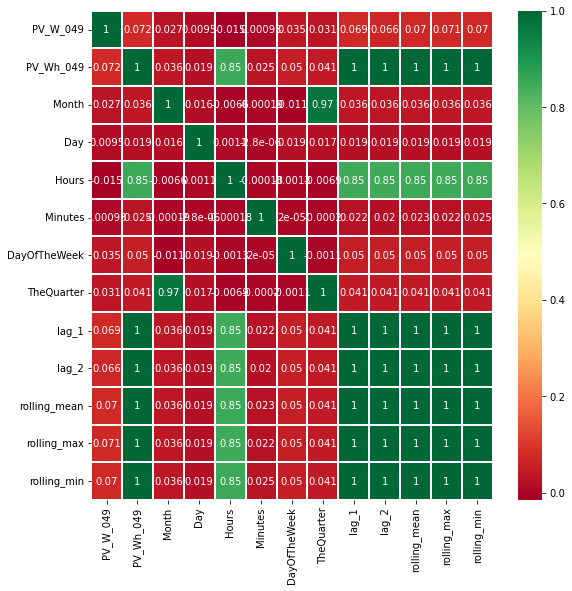

In [166]:
plt.figure(figsize=(9,9))
sns.heatmap(Bldng_049.drop(["Year", "Seconds"], axis=1).corr(), linewidths=.25,cmap="RdYlGn", annot=True)
plt.show()

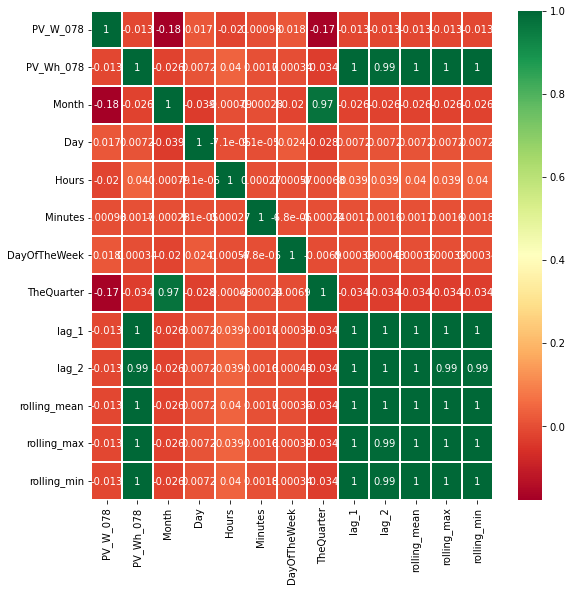

In [167]:
plt.figure(figsize=(9,9))
sns.heatmap(Bldng_078.drop(["Year", "Seconds"], axis=1).corr(), linewidths=.25,cmap="RdYlGn", annot=True)
plt.show()

## Handling Null Values

In [168]:
print("Having performed feature engg steps, check for null values due to rolling window shifts")
Bldng_049.isnull().sum()

Having performed feature engg steps, check for null values due to rolling window shifts


Date            0
Time            0
PV_W_049        0
PV_Wh_049       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
lag_1           1
lag_2           2
rolling_mean    1
rolling_max     1
rolling_min     1
dtype: int64

In [169]:
if Bldng_049.isnull().sum().sum() != 0:
    Bldng_049 = Bldng_049.dropna()
Bldng_049.isnull().sum()

Date            0
Time            0
PV_W_049        0
PV_Wh_049       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
lag_1           0
lag_2           0
rolling_mean    0
rolling_max     0
rolling_min     0
dtype: int64

In [170]:

print("Having performed feature engg steps, check for null values due to rolling window shifts")
Bldng_078.isnull().sum()

Having performed feature engg steps, check for null values due to rolling window shifts


Date            0
Time            0
PV_W_078        0
PV_Wh_078       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
lag_1           1
lag_2           2
rolling_mean    1
rolling_max     1
rolling_min     1
dtype: int64

In [171]:
if Bldng_078.isnull().sum().sum() != 0:
    Bldng_078 = Bldng_078.dropna()
Bldng_078.isnull().sum()

Date            0
Time            0
PV_W_078        0
PV_Wh_078       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
lag_1           0
lag_2           0
rolling_mean    0
rolling_max     0
rolling_min     0
dtype: int64

In [174]:
# Load Buildings Model Feed Data
#Bldng_049.to_csv("C:/Users/csury001/Downloads/bldng049_modelling_input.csv", index=False)
#Bldng_078.to_csv("C:/Users/csury001/Downloads/bldng078_modelling_input.csv", index=False)
#load_model_feed_data(Bldng_049, db_config)
#load_model_feed_data(Bldng_078, db_config)

In [175]:
print("OLS Second pass with all independent vars , droping only non numeric,  and pvwh dependent ...")


OLS Second pass with all independent vars , droping only non numeric,  and pvwh dependent ...


In [176]:
Y1_49 = Bldng_049.PV_Wh_049
X1_49 = Bldng_049.drop(columns=["PV_Wh_049", "Date", "Time", "Year", "Seconds", "Month-str"])
X1_49 = sm.add_constant(X1_49)





D:\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [177]:
X_train_49, X_test_49, y_train_49, y_test_49 = train_test_split(X1_49, Y1_49, test_size=0.3, random_state=1)

print(X_train_49.shape, y_train_49.shape)
print(X_test_49.shape, y_test_49.shape)


(365106, 13) (365106,)
(156475, 13) (156475,)


Note: T-Stastic value for lag_2 feature is insignicant whose value (P>|t|) is 0.756 which is greater than 0.05. Hence let's remove it and carry out with all the rest of features

In [178]:

mlr_49 = sm.OLS(y_train_49, X_train_49).fit()


 
print(mlr_49.summary()) #OLS summary...




                            OLS Regression Results                            
Dep. Variable:              PV_Wh_049   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.088e+32
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:11:05   Log-Likelihood:             6.7110e+06
No. Observations:              365106   AIC:                        -1.342e+07
Df Residuals:                  365094   BIC:                        -1.342e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.612e-10   1.88e-11    -13.889   

In [179]:

train_49_preds = mlr_49.predict(X_train_49)

test_49_preds = mlr_49.predict(X_test_49)

In [180]:
print("RMSE-49 (Train): {}".format(np.sqrt(mean_squared_error(y_train_49, train_49_preds))))
print("RMSE-49 (Test): {}".format(np.sqrt(mean_squared_error(y_test_49, test_49_preds))))
print("R2-49 (Train): {}".format(r2_score(y_train_49, train_49_preds)))
print("R2-49 (Test): {}".format(r2_score(y_test_49, test_49_preds)))

RMSE_49_Train = np.sqrt(mean_squared_error(y_train_49, train_49_preds))
RMSE_49_Test = np.sqrt(mean_squared_error(y_test_49, test_49_preds))
R2_49_Train = r2_score(y_train_49, train_49_preds)
R2_49_Test = r2_score(y_test_49, test_49_preds)


df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'049',
                           'Data':'TRAIN',
                           'RunNumber':'RUN2',
                           'Params':'PARAM_ALL',
                           'RMSE': RMSE_49_Train,
                           'R2': R2_49_Train
                          }, index=[2]) 

rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)

df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'049',
                           'Data':'TEST',
                           'RunNumber':'RUN2',
                           'Params':'PARAM_ALL',
                           'RMSE': RMSE_49_Test,
                           'R2': R2_49_Test
                          }, index=[3]) 


rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)

RMSE-49 (Train): 2.5176704112036194e-09
RMSE-49 (Test): 2.5203089180604605e-09
R2-49 (Train): 1.0
R2-49 (Test): 1.0


In [181]:
rmse_r2_eachmodel

,Model,Building,Data,RunNumber,Params,RMSE,R2
0,OLS,049,TRAIN,RUN1,PARAM1,7.590558e+04,0.722662
1,OLS,049,TEST,RUN1,PARAM1,7.597700e+04,0.722812
2,OLS,049,TRAIN,RUN2,PARAM_ALL,2.517670e-09,1.000000
3,OLS,049,TEST,RUN2,PARAM_ALL,2.520309e-09,1.000000


### Note: RMSE and R2-Score after Rolling Window calculations for OLS model which made it a significant and ideal model

In [182]:
mlr_49.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PV_Wh_049   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.088e+32
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:11:06   Log-Likelihood:             6.7110e+06
No. Observations:              365106   AIC:                        -1.342e+07
Df Residuals:                  365094   BIC:                        -1.342e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.612e-10   1.88e-11    -13.889      0.000   -2.98e-10   -2.24e-10
PV_W_049      4.455e-15   1.17e-15      3.821      0.000    2.17e-15    6.74e-15
Month        -1.458e-11   5.09e-12     -2.863      0.004   -2.46e-11    -4.6e-12
Day           9.202e-13   4.73e-13      1.946      0.052   -6.55e-15    1.85e-12
Hours         2.129e-11   1.17e-12     18.210      0.000     1.9e-11    2.36e-11
Minutes       -1.94e-12   2.41e-13     -8.038      0.000   -2.41e-12   -1.47e-12
DayOfTheWeek  7.674e-13    2.1e-12      0.366      0.714   -3.34e-12    4.88e-12
TheQuarter    4.115e-11   1.57e-11      2.618      0.009    1.03e-11     7.2e-11
lag_1           -1.0000   7.02e-14  -1.43e+13      0.000      -1.000      -1.000
lag_2        -6.328e-15      5e-16    -12.659      0.000   -7.31e-15   -5.35e-15
rolling_mean     0.6667   2.34e-14   2.85e+13      0.000       0.667       0.667
rolling_max      0.6667   5.85e-14   1.14e+13      0.000       0.667       0.667
rolling_min      0.6667   1.17e-14    5.7e+13      0.000       0.667       0.667
==============================================================================
Omnibus:                   158755.851   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35327.344
Skew:                           0.531   Prob(JB):                         0.00
Kurtosis:                       1.908   Cond. No.                     4.25e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.39e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [183]:

print("OLS Third pass with 3 independent vars removed ..." ,"lag_2", "DayOfTheWeek", "Minutes"  ," and pvwh dependent ...")


OLS Third pass with 3 independent vars removed ... lag_2 DayOfTheWeek Minutes  and pvwh dependent ...


In [184]:

Y1_49 = Bldng_049.PV_Wh_049
X1_49 = Bldng_049.drop(columns=["Date", "PV_Wh_049", "Time", "Month-str", "lag_2", "DayOfTheWeek", "Minutes"])
#Bldng_049.Hours
X1_49 = sm.add_constant(X1_49)

D:\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [185]:
X1_train_49, X1_test_49, y1_train_49, y1_test_49 = train_test_split(X1_49, Y1_49, test_size=0.3, random_state=1)

In [186]:
mlr_49 = sm.OLS(y1_train_49, X1_train_49).fit()
print(mlr_49.summary())

                            OLS Regression Results                            
Dep. Variable:              PV_Wh_049   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.089e+08
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:11:07   Log-Likelihood:            -3.4352e+06
No. Observations:              365106   AIC:                         6.870e+06
Df Residuals:                  365097   BIC:                         6.871e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
PV_W_049      9.118e-15      0.001   6.67e-12   

In [187]:

train_49_preds = mlr_49.predict(X1_train_49)
test_49_preds = mlr_49.predict(X1_test_49)

In [188]:
train_49_preds
act_pred_df= pd.DataFrame({'Actual': y1_test_49, 'Predicted': test_49_preds})
print(len(act_pred_df))
print(act_pred_df.sort_index().tail(5))


156475
                     Actual      Predicted
Date_Time                                 
2021-12-31 23:54:00  234392  237714.603882
2021-12-31 23:55:00  234392  237714.603882
2021-12-31 23:56:00  234392  237714.603882
2021-12-31 23:58:00  234392  237714.603882
2021-12-31 23:59:00  234392  237714.603882


In [189]:
print("RMSE-49 (Train): {}".format(np.sqrt(mean_squared_error(y_train_49, train_49_preds))))
print("RMSE-49 (Test): {}".format(np.sqrt(mean_squared_error(y_test_49, test_49_preds))))
print("R2-49 (Train): {}".format(r2_score(y_train_49, train_49_preds)))
print("R2-49 (Test): {}".format(r2_score(y_test_49, test_49_preds)))

RMSE_49_Train = np.sqrt(mean_squared_error(y_train_49, train_49_preds))
RMSE_49_Test = np.sqrt(mean_squared_error(y_test_49, test_49_preds))
R2_49_Train = r2_score(y_train_49, train_49_preds)
R2_49_Test = r2_score(y_test_49, test_49_preds)


df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'049',
                           'Data':'TRAIN',
                           'RunNumber':'RUN3',
                           'Params':'PARAM_ALL_MINUS',
                           'RMSE': RMSE_49_Train,
                           'R2': R2_49_Train
                          }, index=[4]) 

rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)

df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'049',
                           'Data':'TEST',
                           'RunNumber':'RUN3',
                           'Params':'PARAM_ALL_MINUS',
                           'RMSE': RMSE_49_Test,
                           'R2': R2_49_Test
                          }, index=[5]) 


rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)
rmse_r2_eachmodel

RMSE-49 (Train): 2950.804887414041
RMSE-49 (Test): 2953.7129298834025
R2-49 (Train): 0.9995810693476689
R2-49 (Test): 0.999580611540621


,Model,Building,Data,RunNumber,Params,RMSE,R2
0,OLS,049,TRAIN,RUN1,PARAM1,7.590558e+04,0.722662
1,OLS,049,TEST,RUN1,PARAM1,7.597700e+04,0.722812
2,OLS,049,TRAIN,RUN2,PARAM_ALL,2.517670e-09,1.000000
3,OLS,049,TEST,RUN2,PARAM_ALL,2.520309e-09,1.000000
4,OLS,049,TRAIN,RUN3,PARAM_ALL_MINUS,2.950805e+03,0.999581
5,OLS,049,TEST,RUN3,PARAM_ALL_MINUS,2.953713e+03,0.999581


## Multiple Linear Regression Interpretation:
### Regression Model for Building 49 has the following equation, PV_Wh_049 = (3.292e-15)xPV_W_049 + (1.021e-09)xHours - (1.0000)xlag_1 - (0.6512)xrolling_mean + (1.3256)xrolling_max + (1.3256)xrolling_min

In [190]:
dep_49 = Bldng_049.PV_Wh_049
ind_49 = Bldng_049.drop(columns=["PV_W_049", "PV_Wh_049","Day", "Minutes", "Seconds", "lag_2", "rolling_mean", "rolling_max", "rolling_min"])

In [191]:
X_tr, X_te, y_tr, y_te = train_test_split(ind_49, dep_49, test_size=0.3, random_state=1)

In [192]:
ml_errors_49 = pd.DataFrame()
ml_errors_49['Actual_PVWh'] = y1_test_49
ml_errors_49['Predicted_PVWh'] = test_49_preds
ml_errors_49['Bias_Error'] = ml_errors_49['Predicted_PVWh'] - ml_errors_49['Actual_PVWh']
ml_errors_49.insert(0, 'Modelname', 'OLS')
ml_errors_49.insert(1, 'Building', '49')
ml_errors_49 = ml_errors_49.reset_index(drop = True)
ml_errors_49.head()

,Modelname,Building,Actual_PVWh,Predicted_PVWh,Bias_Error
0,OLS,49,42,4.259537e+01,5.953674e-01
1,OLS,49,0,-1.155714e-11,-1.155714e-11
2,OLS,49,0,-4.089901e-11,-4.089901e-11
3,OLS,49,94568,9.590394e+04,1.335944e+03
4,OLS,49,0,-6.443929e-11,-6.443929e-11


In [193]:
#X1_train_49, X1_test_49, y1_train_49, y1_test_49
ml_errors_49["Date"] = X_te.Date.values
#ml_errors_49["Date_Time"] = X_te.Date_Time.values
ml_errors_49["Month"] = X_te.Month.values
ml_errors_49["Month-str"] = X_te["Month-str"].values
ml_errors_49["Hours"] = X_te["Hours"].values
ml_errors_49.head()

,Modelname,Building,Actual_PVWh,Predicted_PVWh,Bias_Error,Date,Month,Month-str,Hours
0,OLS,49,42,4.259537e+01,5.953674e-01,2021-01-24,1,January,5
1,OLS,49,0,-1.155714e-11,-1.155714e-11,2021-04-21,4,April,4
2,OLS,49,0,-4.089901e-11,-4.089901e-11,2021-10-04,10,October,3
3,OLS,49,94568,9.590394e+04,1.335944e+03,2021-08-20,8,August,10
4,OLS,49,0,-6.443929e-11,-6.443929e-11,2021-06-22,6,June,1


## Building-78

In [194]:
print("Bivarariate regression ..078")

Y_78 = Bldng_078.PV_W_078
#X_78 = Bldng_078.drop(columns=["Date", "Time", "PV_Wh_078", "Date_Time", "Year","Day", "Minutes", "Seconds", "Month", "Month-str"])
X_78 = Bldng_078.Hours


Bivarariate regression ..078


In [195]:
X_train_78, X_test_78, y_train_78, y_test_78 = train_test_split(X_78, Y_78, test_size=0.3, random_state=1)

In [196]:
X_train_78.shape, y_train_78.shape


((352367,), (352367,))

In [197]:
X_test_78.shape, y_test_78.shape

((151015,), (151015,))

In [198]:
ols_78 = sm.OLS(y_train_78, X_train_78).fit()

# Print out the statistics
ols_78.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               PV_W_078   R-squared (uncentered):                   0.191
Model:                            OLS   Adj. R-squared (uncentered):              0.191
Method:                 Least Squares   F-statistic:                          8.327e+04
Date:                Thu, 03 Nov 2022   Prob (F-statistic):                        0.00
Time:                        11:11:09   Log-Likelihood:                     -3.7900e+06
No. Observations:              352367   AIC:                                  7.580e+06
Df Residuals:                  352366   BIC:                                  7.580e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hours        410.9648      1.424    288.560      0.000     408.173     413.756
==============================================================================
Omnibus:                   107503.336   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           289311.897
Skew:                           1.657   Prob(JB):                         0.00
Kurtosis:                       5.954   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [199]:
train_78_preds = ols_78.predict(X_train_78)
test_78_preds = ols_78.predict(X_test_78)

In [200]:
print("RMSE-78 (Train): {}".format(np.sqrt(mean_squared_error(y_train_78, train_78_preds))))
print("RMSE-78 (Test): {}".format(np.sqrt(mean_squared_error(y_test_78, test_78_preds))))

RMSE-78 (Train): 11348.50423674813
RMSE-78 (Test): 11343.968945235893


In [201]:
print("R2-78 (Train): {}".format(r2_score(y_train_78, train_78_preds)))
print("R2-78 (Test): {}".format(r2_score(y_test_78, test_78_preds)))

R2-78 (Train): -0.11012159112808284
R2-78 (Test): -0.1095073845524479


In [202]:
RMSE_78_Train = np.sqrt(mean_squared_error(y_train_78, train_78_preds))
RMSE_78_Test = np.sqrt(mean_squared_error(y_test_78, test_78_preds))
R2_78_Train = r2_score(y_train_78, train_78_preds)
R2_78_Test = r2_score(y_test_78, test_78_preds)


 

rmse_r2_eachmodel= pd.DataFrame({'Model':'OLS',
                            'Building':'078',
                           'Data':'TRAIN',
                           'RunNumber':'RUN1',
                           'Params':'PARAM1',
                           'RMSE': RMSE_78_Train,
                           'R2': R2_78_Train
                          }, index=[0]) 

df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'078',
                           'Data':'TEST',
                           'RunNumber':'RUN1',
                           'Params':'PARAM1',
                           'RMSE': RMSE_78_Test,
                           'R2': R2_78_Test
                          }, index=[1]) 


rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)

In [203]:
print(rmse_r2_eachmodel)

  Model Building   Data RunNumber  Params          RMSE        R2
0   OLS      078  TRAIN      RUN1  PARAM1  11348.504237 -0.110122
1   OLS      078   TEST      RUN1  PARAM1  11343.968945 -0.109507


## Feature Engineering (Using Rolling Window Calculations)

In [204]:
# Lag features and Shift index
for i in range(1,3):
    lag_i = 'lag_' + str(i)
    Bldng_078[lag_i] = Bldng_078.PV_W_078.shift(i)
    
# Rolling window
Bldng_078['rolling_mean'] = Bldng_078.PV_W_078.rolling(window=2).mean()
Bldng_078['rolling_max'] = Bldng_078.PV_W_078.rolling(window=2).max()
Bldng_078['rolling_min'] = Bldng_078.PV_W_078.rolling(window=2).min()

C:\Users\sheer\AppData\Local\Temp/ipykernel_3884/1499198135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bldng_078[lag_i] = Bldng_078.PV_W_078.shift(i)


<AxesSubplot:>

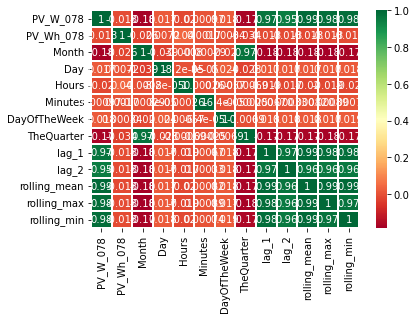

In [205]:
sns.heatmap(Bldng_078.drop(["Year", "Seconds"], axis=1).corr(), linewidths=.25,cmap="RdYlGn", annot=True)


In [206]:
print("Having performed feature engg steps, check for null values due to rolling window shifts")
Bldng_078.isnull().sum()

Having performed feature engg steps, check for null values due to rolling window shifts


Date            0
Time            0
PV_W_078        0
PV_Wh_078       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
lag_1           1
lag_2           2
rolling_mean    1
rolling_max     1
rolling_min     1
dtype: int64

In [207]:
if Bldng_078.isnull().sum().sum() != 0:
    Bldng_078 = Bldng_078.dropna()
Bldng_078.isnull().sum()

Date            0
Time            0
PV_W_078        0
PV_Wh_078       0
Year            0
Month           0
Day             0
Hours           0
Minutes         0
Seconds         0
Month-str       0
DayOfTheWeek    0
TheQuarter      0
lag_1           0
lag_2           0
rolling_mean    0
rolling_max     0
rolling_min     0
dtype: int64

In [208]:

print("OLS Second pass with all independent vars , droping only non numeric,  and pvwh dependent ...078")


OLS Second pass with all independent vars , droping only non numeric,  and pvwh dependent ...078


In [209]:
Y1_78 = Bldng_078.PV_W_078
X1_78 = Bldng_078.drop(columns=["PV_W_078", "Date", "Time", "Year", "Seconds", "Month-str"])
X1_78 = sm.add_constant(X1_78)




D:\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [210]:
X_train_78, X_test_78, y_train_78, y_test_78 = train_test_split(X1_78, Y1_78, test_size=0.3, random_state=1)

print(X_train_78.shape, y_train_78.shape)
print(X_test_78.shape, y_test_78.shape)

(352366, 13) (352366,)
(151014, 13) (151014,)


In [211]:

mlr_78 = sm.OLS(y_train_78, X_train_78).fit()



In [212]:

train_78_preds = mlr_78.predict(X_train_78)

test_78_preds = mlr_78.predict(X_test_78)

In [213]:
print("RMSE-78 (Train): {}".format(np.sqrt(mean_squared_error(y_train_78, train_78_preds))))
print("RMSE-78 (Test): {}".format(np.sqrt(mean_squared_error(y_test_78, test_78_preds))))
print("R2-78 (Train): {}".format(r2_score(y_train_78, train_78_preds)))
print("R2-78 (Test): {}".format(r2_score(y_test_78, test_78_preds)))

RMSE_78_Train = np.sqrt(mean_squared_error(y_train_78, train_78_preds))
RMSE_78_Test = np.sqrt(mean_squared_error(y_test_78, test_78_preds))
R2_78_Train = r2_score(y_train_78, train_78_preds)
R2_78_Test = r2_score(y_test_78, test_78_preds)


df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'078',
                           'Data':'TRAIN',
                           'RunNumber':'RUN2',
                           'Params':'PARAM_ALL',
                           'RMSE': RMSE_78_Train,
                           'R2': R2_78_Train
                          }, index=[2]) 

rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)

df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'078',
                           'Data':'TEST',
                           'RunNumber':'RUN2',
                           'Params':'PARAM_ALL',
                           'RMSE': RMSE_78_Test,
                           'R2': R2_78_Test
                          }, index=[3]) 


rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)

RMSE-78 (Train): 2.190541325105815e-10
RMSE-78 (Test): 2.1761054526568515e-10
R2-78 (Train): 1.0
R2-78 (Test): 1.0


In [214]:
rmse_r2_eachmodel

,Model,Building,Data,RunNumber,Params,RMSE,R2
0,OLS,078,TRAIN,RUN1,PARAM1,1.134850e+04,-0.110122
1,OLS,078,TEST,RUN1,PARAM1,1.134397e+04,-0.109507
2,OLS,078,TRAIN,RUN2,PARAM_ALL,2.190541e-10,1.000000
3,OLS,078,TEST,RUN2,PARAM_ALL,2.176105e-10,1.000000


### Note: RMSE and R2-Score after Rolling Window calculations for OLS model which made it a significant and ideal model -078

In [215]:
mlr_78.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PV_W_078   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.735e+31
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:11:13   Log-Likelihood:             7.3372e+06
No. Observations:              352366   AIC:                        -1.467e+07
Df Residuals:                  352354   BIC:                        -1.467e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.42e-11   1.61e-12     -8.831      0.000   -1.73e-11    -1.1e-11
PV_Wh_078    -2.217e-17   3.76e-20   -589.237      0.000   -2.22e-17   -2.21e-17
Month        -3.384e-13   4.59e-13     -0.737      0.461   -1.24e-12    5.62e-13
Day          -2.331e-14   4.22e-14     -0.552      0.581   -1.06e-13    5.94e-14
Hours         6.838e-14   5.33e-14      1.283      0.199    -3.6e-14    1.73e-13
Minutes      -2.787e-14   2.13e-14     -1.309      0.191   -6.96e-14    1.39e-14
DayOfTheWeek  1.679e-13   1.84e-13      0.911      0.362   -1.93e-13    5.29e-13
TheQuarter    3.292e-12   1.39e-12      2.366      0.018    5.65e-13    6.02e-12
lag_1           -1.0000   2.72e-16  -3.67e+15      0.000      -1.000      -1.000
lag_2         5.516e-16   1.34e-16      4.102      0.000    2.88e-16    8.15e-16
rolling_mean     0.6667   8.98e-17   7.42e+15      0.000       0.667       0.667
rolling_max      0.6667   1.66e-16   4.03e+15      0.000       0.667       0.667
rolling_min      0.6667   1.73e-16   3.84e+15      0.000       0.667       0.667
==============================================================================
Omnibus:                  1029005.674   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      43647217404.992
Skew:                          41.368   Prob(JB):                         0.00
Kurtosis:                    1725.211   Cond. No.                     2.38e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.01e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [216]:
print("OLS Third pass with 3 independent vars removed ..." ,"lag_2", "DayOfTheWeek", "Minutes"  ," and pvwh dependent ...")


OLS Third pass with 3 independent vars removed ... lag_2 DayOfTheWeek Minutes  and pvwh dependent ...


In [217]:

Y1_78 = Bldng_078.PV_W_078
X1_78 = Bldng_078.drop(columns=["Date", "PV_W_078", "Time", "Month-str", "lag_2", "DayOfTheWeek", "Minutes"])
#Bldng_078.Hours
X1_78 = sm.add_constant(X1_78)

D:\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [218]:
X1_train_78, X1_test_78, y1_train_78, y1_test_78 = train_test_split(X1_78, Y1_78, test_size=0.3, random_state=1)

In [219]:
mlr_78 = sm.OLS(y1_train_78, X1_train_78).fit()
print(mlr_78.summary())

                            OLS Regression Results                            
Dep. Variable:               PV_W_078   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.295e+29
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:11:14   Log-Likelihood:             6.4335e+06
No. Observations:              352366   AIC:                        -1.287e+07
Df Residuals:                  352357   BIC:                        -1.287e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
PV_Wh_078     2.897e-16   4.89e-19    592.247   

In [220]:

train_78_preds = mlr_78.predict(X1_train_78)
test_78_preds = mlr_78.predict(X1_test_78)

In [221]:
train_78_preds
act_pred_df= pd.DataFrame({'Actual': y1_test_78, 'Predicted': test_78_preds})
print(len(act_pred_df))
print(act_pred_df.sort_index().tail(5))


151014
                     Actual     Predicted
Date_Time                                
2021-12-21 01:19:00       0 -6.670386e-12
2021-12-21 01:21:00       0 -6.670386e-12
2021-12-21 01:31:00       0 -6.670386e-12
2021-12-21 01:33:00       0 -6.670386e-12
2021-12-21 01:36:00       0 -6.670386e-12


In [222]:
print("RMSE-78 (Train): {}".format(np.sqrt(mean_squared_error(y_train_78, train_78_preds))))
print("RMSE-78 (Test): {}".format(np.sqrt(mean_squared_error(y_test_78, test_78_preds))))
print("R2-78 (Train): {}".format(r2_score(y_train_78, train_78_preds)))
print("R2-78 (Test): {}".format(r2_score(y_test_78, test_78_preds)))

RMSE_78_Train = np.sqrt(mean_squared_error(y_train_78, train_78_preds))
RMSE_78_Test = np.sqrt(mean_squared_error(y_test_78, test_78_preds))
R2_78_Train = r2_score(y_train_78, train_78_preds)
R2_78_Test = r2_score(y_test_78, test_78_preds)


df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'078',
                           'Data':'TRAIN',
                           'RunNumber':'RUN3',
                           'Params':'PARAM_ALL_MINUS',
                           'RMSE': RMSE_78_Train,
                           'R2': R2_78_Train
                          }, index=[4]) 

rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)

df_temp1=  pd.DataFrame({'Model':'OLS',
                            'Building':'078',
                           'Data':'TEST',
                           'RunNumber':'RUN3',
                           'Params':'PARAM_ALL_MINUS',
                           'RMSE': RMSE_78_Test,
                           'R2': R2_78_Test
                          }, index=[5]) 


rmse_r2_eachmodel = rmse_r2_eachmodel.append(df_temp1, ignore_index = True)
rmse_r2_eachmodel

RMSE-78 (Train): 2.8472501122432145e-09
RMSE-78 (Test): 2.828301152410014e-09
R2-78 (Train): 1.0
R2-78 (Test): 1.0


,Model,Building,Data,RunNumber,Params,RMSE,R2
0,OLS,078,TRAIN,RUN1,PARAM1,1.134850e+04,-0.110122
1,OLS,078,TEST,RUN1,PARAM1,1.134397e+04,-0.109507
2,OLS,078,TRAIN,RUN2,PARAM_ALL,2.190541e-10,1.000000
3,OLS,078,TEST,RUN2,PARAM_ALL,2.176105e-10,1.000000
4,OLS,078,TRAIN,RUN3,PARAM_ALL_MINUS,2.847250e-09,1.000000
5,OLS,078,TEST,RUN3,PARAM_ALL_MINUS,2.828301e-09,1.000000


In [223]:
Ynew_78 = Bldng_078.PV_W_078
Xnew_78 = Bldng_078.drop(columns=["Date", "Time", "PV_W_078", "PV_Wh_078", "Hours", "Year","Day", "Minutes", "Seconds", "Month", "Month-str", "lag_2", "rolling_max", "rolling_mean", "rolling_min"])
#X1_78 = Bldng_078.drop(columns=["Date", "PV_Wh_078", "Time", "Month-str", "lag_2", "DayOfTheWeek", "Minutes"])

new_ols_78 = sm.OLS(Ynew_78, Xnew_78).fit()

# Print out the statistics
new_ols_78.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               PV_W_078   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                          3.208e+06
Date:                Thu, 03 Nov 2022   Prob (F-statistic):                        0.00
Time:                        11:11:15   Log-Likelihood:                     -4.7120e+06
No. Observations:              503380   AIC:                                  9.424e+06
Df Residuals:                  503377   BIC:                                  9.424e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
DayOfTheWeek    33.2703      1.722     19.323      0.000      29.896      36.645
TheQuarter      28.6186      2.282     12.543      0.000      24.147      33.090
lag_1            0.9680      0.000   2738.392      0.000       0.967       0.969
==============================================================================
Omnibus:                   235858.570   Durbin-Watson:                   2.403
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        117911024.339
Skew:                           0.913   Prob(JB):                         0.00
Kurtosis:                      77.956   Cond. No.                     8.46e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression model for Building 78 has the below equation,

### PV_Wh_078 = (0.9965)Xlag_1

In [224]:
X1_train_78, X1_test_78, y1_train_78, y1_test_78 = train_test_split(Xnew_78, Ynew_78, test_size=0.3, random_state=1)

In [225]:
train_preds_78 = new_ols_78.predict(X1_train_78)
test_preds_78 = new_ols_78.predict(X1_test_78)

In [226]:
print("Final RMSE-78 (Train): {}".format(np.sqrt(mean_squared_error(y1_train_78, train_preds_78))))
print("Final RMSE-78 (Test): {}".format(np.sqrt(mean_squared_error(y1_test_78, test_preds_78))))

Final RMSE-78 (Train): 2802.578265876566
Final RMSE-78 (Test): 2835.0456427830018


In [227]:
print("Final R2-78 (Train): {}".format(r2_score(y1_train_78, train_preds_78)))
print("Final R2-78 (Test): {}".format(r2_score(y1_test_78, test_preds_78)))

Final R2-78 (Train): 0.932213617858599
Final R2-78 (Test): 0.9309003054350087


In [228]:
ml_errors_78 = pd.DataFrame()
ml_errors_78['Actual_PVWh'] = y1_test_78
ml_errors_78['Predicted_PVWh'] = test_preds_78
ml_errors_78['Bias_Error'] = ml_errors_78['Predicted_PVWh'] - ml_errors_78['Actual_PVWh']
ml_errors_78.insert(0, 'Modelname', 'OLS')
ml_errors_78.insert(1, 'Building', '78')
ml_errors_78 = ml_errors_78.reset_index(drop=True)
ml_errors_78.head()

,Modelname,Building,Actual_PVWh,Predicted_PVWh,Bias_Error
0,OLS,78,5594,5624.199780,30.199780
1,OLS,78,19505,46048.927917,26543.927917
2,OLS,78,11,233.457814,222.457814
3,OLS,78,3292,3249.859855,-42.140145
4,OLS,78,26051,25412.051862,-638.948138


In [229]:
d_78 = Bldng_078.PV_Wh_078
i_78 = Bldng_078.drop(columns=["PV_W_078", "PV_Wh_078","Day", "Minutes", "Seconds", "lag_2", "rolling_mean", "rolling_max", "rolling_min"])

In [230]:
X_tra, X_tes, y_tra, y_tes = train_test_split(i_78,d_78, test_size=0.3, random_state=1)

In [231]:
X_tes.shape, ml_errors_78.shape

((151014, 9), (151014, 5))

In [232]:
ml_errors_78["Date"] = X_tes.Date.values
#ml_errors_78["Date_Time"] = X_tes.Date_Time.values
ml_errors_78["Month"] = X_tes.Month.values
ml_errors_78["Month-str"] = X_tes["Month-str"].values
ml_errors_78["Hours"] = X_tes["Hours"].values
ml_errors_78.head()

,Modelname,Building,Actual_PVWh,Predicted_PVWh,Bias_Error,Date,Month,Month-str,Hours
0,OLS,78,5594,5624.199780,30.199780,2021-07-11,7,July,8
1,OLS,78,19505,46048.927917,26543.927917,2021-03-13,3,March,10
2,OLS,78,11,233.457814,222.457814,2021-07-02,7,July,23
3,OLS,78,3292,3249.859855,-42.140145,2021-09-03,9,September,9
4,OLS,78,26051,25412.051862,-638.948138,2021-06-07,6,June,13


In [234]:
ml_errors_49.to_csv('C:/Users/sheer/OneDrive/Documents/digital_twin_project/Downloads/Building_49_Model_Output.csv', index=False)
ml_errors_78.to_csv('C:/Users/sheer/OneDrive/Documents/digital_twin_project/Downloads/Bldng_078_Model_Output.csv', index=False)
#load_df_db(ml_errors_49, db_config)
#load_df_db(ml_errors_78, db_config)|

In [235]:
joblib.dump(mlr_49, "C:/Users/sheer/OneDrive/Documents/digital_twin_project/Downloads/Bldng_49_ols.pkl")
joblib.dump(new_ols_78, "C:/Users/sheer/OneDrive/Documents/digital_twin_project/Downloads/Bldng_78_ols.pkl")

['C:/Users/sheer/OneDrive/Documents/digital_twin_project/Downloads/Bldng_78_ols.pkl']

<Figure size 864x648 with 0 Axes>

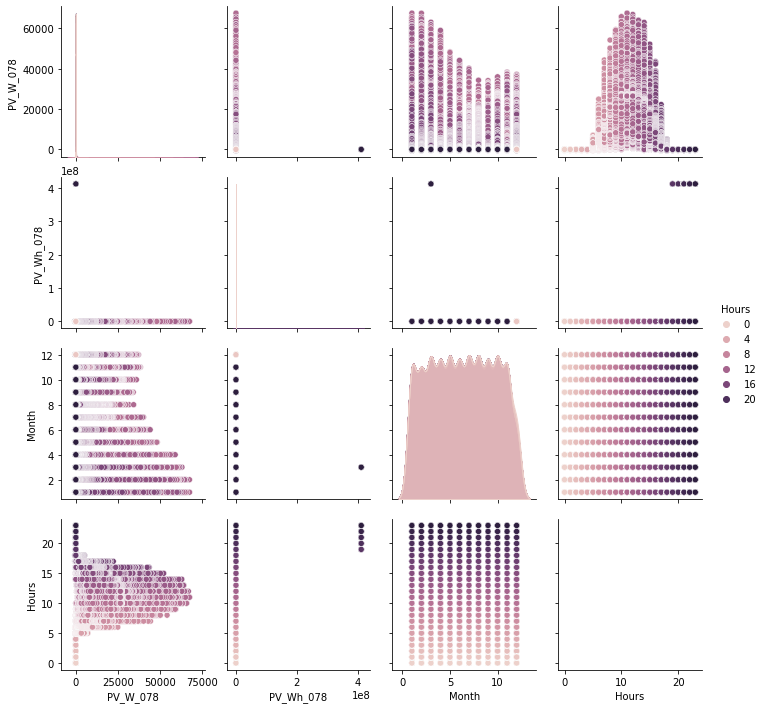

In [236]:
%matplotlib inline

 

plt.figure(figsize=(12,9))
sns.pairplot(Bldng_078, vars=['PV_W_078', 'PV_Wh_078', 'Month', 'Hours'], hue='Hours')
plt.show()

 